<a id='logbook'></a>
# Prediction of ship roll decay motion using fully nonlinear potential flow and Ikeda’s method

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
# %load ../../notebooks/imports.py
"""
These is the standard setup for the notebooks.
"""

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize
from rolldecayestimators import equations_ikeda_naked
from sympy import latex
from rolldecayestimators import logarithmic_decrement
from copy import deepcopy
import src.helpers
from src.notebook_to_latex import Equation

## Examples:
from reports import mdl_results
import reports.examples as examples
import reports.examples.ikeda_V_phi_a
import reports.examples.analytical_numerical
import reports.examples.eddy_sigma
import reports.examples.ikeda_section_table
import reports.examples.decision_tree
import reports.examples.KVLCC2_section_table
import reports.examples.logaritimic_decrement
import reports.examples.mdl
from reports.examples.mdl import plot_amplitudes
import reports.examples.ikeda
import reports.examples.hybrid_0
import reports.examples.hybrid_speed
import reports.examples.FNPF
import reports.examples.KVLCC2

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Many cost-efficient computational methods have been developed over the
years to analyze various aspects of ship hydrodynamics such as:
resistance, propulsion and seakeeping. Getting the best possible
accuracy with the lowest possible computational cost is an important
factor in a ship's early design stage. Potential flow-based analysis
partly presents such a solution for seakeeping, with good accuracy for
heave and pitch, but not for roll where the roll damping contains both
inviscid and viscous effects. Roll motion is, however, often a critical
degree of freedom that needs to be analyzed since large roll motions can
result in cargo shifting or even capsizing. The viscous part of roll
damping can be assessed with high accuracy by means of experimental
model tests or URANS calculations, but these are generally too expensive
in the early design stage of ships. Many semi-empirical formulas to
determine viscous damping were therefore developed during the 1970s,
where Ikeda's method is one of the most widely used. The viscous damping
from this method is normally combined with inviscid roll damping from
strip theory. With today's computational power, more advanced potential
flow methods can be used in the seakeeping analysis to enhance the
accuracy in the predictions, but still at relatively low computational
cost. This paper investigates the feasibility of combining 3D unsteady
fully nonlinear potential flow (FNPF) theory solved by means of a
Boundary Element Method (BEM) together with the viscous contributions
from Ikeda's method. Roll decay simulations with the hybrid method proposed in this paper show very good agreement with corresponding model tests for the investigated KVLCC2 test case. Even though this approach has been investigated for such a simple case as the roll decay test and for only one ship, it is believed to be an improvement in seakeeping potential flow simulations.  

# Nomenclature
| Variable | Explain |
|---|---|
|$\pi$| example |

# Introduction
The motions of a ship in a seaway can be predicted with good accuracy using potential flow <cite data-cite="7505983/FB64RGPF"></cite> to predic the pitch and heave motions at very low computational cost. These methods are therefore widely used to predict ship responses during the early design stage of ships. The roll motion is however highly influenced by viscous roll damping, which is neglected by these methods, giving a very unrealistic roll motion representation. But the roll motions can of course not be dissregarded in the analysis of motions. The impact of roll motions can be seen from the APL China casualty in 1998, where a post-Panamax C11 class container ship lost almost a third of its containers. Even newer ships as the ONE APUS a 14,052 TEU containership built in 2019 lost more than 1000 containers during heavy roll motions. 

A lot of experimental research was conducted during the 70th and 80thout to separate the inviscid and viscous damping <cite data-cite="7505983/937PN5DT"></cite>. Semi empirical formulas were developed to estimate the viscous parts to be used together with the potential flow methods. 
Today the linear potential flow methods have (to a large extent) been replaced by more advanced nonlinear methods. <cite data-cite="7505983/UGK6YEVD"></cite> has shown that the separation of viscous and inviscous damping is still valid for a panel method and Ikeda's method to predict the roll motion for the mentioned APL China vessel. <cite data-cite="7505983/24TNAV5Z"></cite> has investigated an even more advanced method, using a fully nonlinear potential flow method (FNPF) combined with Watanabe and Inoue (WI) method to predict the viscous damping for the DTC <cite data-cite="7505983/BYNJ8CFG"></cite> and Series60 ships. The FNPF method is used also in the present paper, but instead of WI method, Ikeda's method is used, as a new hybrid method. Ikeda's method is belived to be a good method for this purpose, based on the result from comparison with a large number of model scale roll decay tests <cite data-cite="7505983/QMGQ76Q9"></cite>.

The implementation of the proposed hybrid method is introduced in the next section where the underlying Ikeda's method and FNPF method are both presented. Ikeda's method is also thurougly investigated.

#  Proposed hybrid method
A hybrid method is proposed, where wave damping $B_W$ (including the speed dependent wave damping)  obtained implicitly with FNPF is used together with the viscous damping contributions from Ikeda's method. The viscous damping is added to the FNPF simulations by adding the viscous parts of the linear and quadratic damping coefficients (obtained with Ikeda's method) to the equation of motion.

Ikeda's method divides roll damping into five damping components: 

|  Symbol   | Component                    |   
| --------- | ---------------------------- |
|  $B_F$    | skin friction        |     
|  $B_E$    | eddy generation            |
|  $B_L$    | hull lift            | 
|  $B_W$    | roll wave generation            | 
|  $B_{BK}$ | bilge keels  | 

The total damping is calculated as the sum of these components <cite data-cite="7505983/937PN5DT"></cite>,
\begin{equation}
B = B_F + B_E + B_L + B_W + B_{BK}
\end{equation}

Ikeda has in a series of papers proposed semi empirical formulas for the viscous damping components: $B_F$, $B_E$, $B_{BK}$ and $B_L$ so that viscous damping can be obtained from, 

\begin{equation}
\label{eq:viscous damping}
B_{visc} = B_F + B_E + B_L + B_{BK}
\end{equation}

Due to the absence of bilge keels for the KVLCC2 the $B_{BK}$ does not need to be included in the viscous damping. This means that remaining components will get all the attention in this paper.

Ikeda produced many papers about various aspects of roll damping where most of them are translations from original manuscripts written in Japanese. Summaries of this method <cite data-cite="7505983/FB64RGPF"></cite>, <cite data-cite="7505983/KAKIM2E2"></cite> and <cite data-cite="7505983/UGK6YEVD"></cite> has been used together with the original papers to understand how the method should be implemented. Falzarano says that the Himeno report and associated computer programs are well-known to have numerous typographical errors. When looking at these resources it becomes evident that there is some variety on how the method should be implemented, regardless if this is due to typographical errors or being variations of the actual method. The implementation was therefore a fairly time consuming task where various alternative implementations needed to be compared and investigated. 

The scale effects of roll damping is considered to mainly be associated with the skin friction component $B_F$ <cite data-cite="7505983/FB64RGPF"></cite>. This component constitute a very small part of the total damping for the full scale ship, but a substantial part for the model scale ship used in this study. This is therefore the only component in Ikedas method that needs to be recalculated when the scale changes.  

For the skin friction damping $B_F$ implementation was made according to the description in <cite data-cite="7505983/UGK6YEVD"></cite>. With the difference that the actual wetted surface at rest $S$ was used instead of the proposed estimation formula. 

The hull lift damping $B_L$ is calculated according to <cite data-cite="7505983/937PN5DT"></cite> and implemented as described in <cite data-cite="7505983/UYUAYY7E"></cite>. Journée added a linear interpolation to the values for $\kappa$ from the Ikeda's paper.

Ikeda's method calculates the roll damping at a certain roll angle frequency $\omega$ and roll angle amplitude $\phi_a$. A schematic graph of how the parameters vary with speed and roll angle amplitude $\phi_a$ is shown in fig.[(below)](#fig_ikeda_generic). The roll amplitude is first varied at zero speed (left). The speed is then varied from zero to the froude number corresponding to 15.5 knots in full scale for the KVLCC2 with a roll angle amplitude of 10 degrees (middle). The amplitude is then gradually reduced at the highest froude number down to zero  again (right). 

Assumming that the trends are correct in Ikeda's method it can be noted from the amplitude variations at zero knots (left):
* $B_W$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping. (The $B_W$ was calculated with strip theory here)
* $B_F$ has a small amplitude dependancy but the linear part is dominating.
* $B_E$ has a large amplitude depandancy and only contributes to the quadratic damping ($B_2$)<cite data-cite="7505983/4AFVVGNT"></cite>.

Looking at the speed variation (middle):
* At low speed $B_F$ and $B_E$ are the dominating components. (Note that this ship does not have bilge keels, as that would otherwise also be a large component).
* At high speed the $B_E$ has almost disappeared and is replaced by the $B_L$ which is now the dominating component.
* $B_F$ has a large contribution for all speeds (at model scale).

Looking at the roll amplitude variation (right):
* (Please note that this x-axis is revered in this graph)
* $B_L$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping.
* $B_F$ has a small amplitude dependancy but the linear part is dominating.

<a id='fig_ikeda_generic'></a>

findfont: Font family ['"serif"'] not found. Falling back to DejaVu Sans.


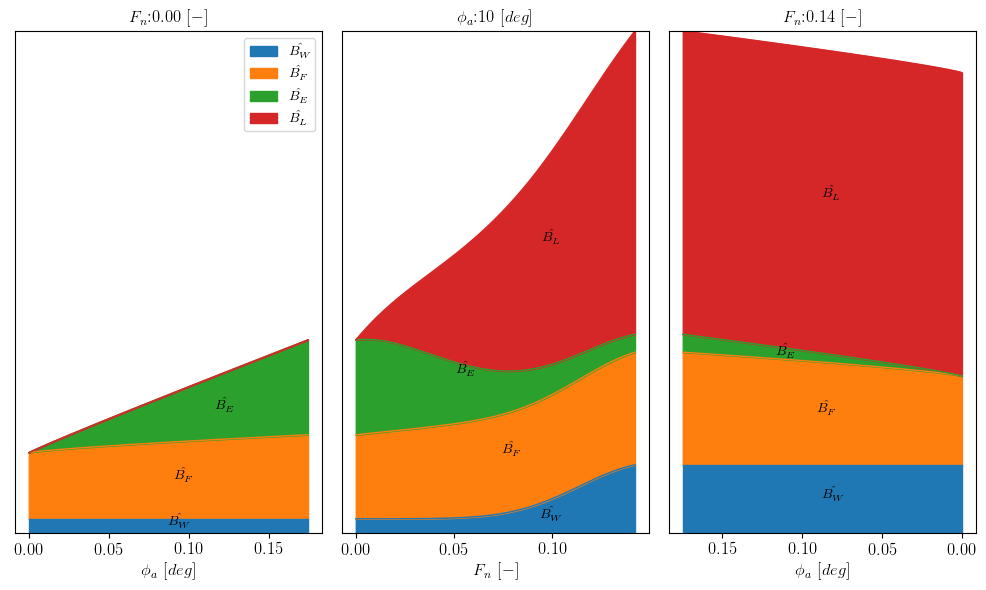

In [6]:
examples.ikeda_V_phi_a.show()

When the damping predicted with Ikeda's method was compared with corresponding
model test it was found that the results were in poor agreement for the
zero speed case but quite good results at speed. This was pointing
towards the eddy damping being incorrect in the current implementation
of Ikeda's method. A thorough investigation of the eddy damping
prediction was therefore conducted which is described in the next
section.

## Eddy damping
The eddy damping is due to eddies generated around the ship hull during the roll motion. Strong eddies occures at sharp edges in the geometry. Below is an illustration of how the eddy damping changes with bilge radius to beam ratio as predicted with the current implementation of the method. It seems that the damping approaches zero very fast as the bilge radius increase. So having just a small rounding of the bilge, compared to a square section, will have a great impact on the eddy roll damping.  

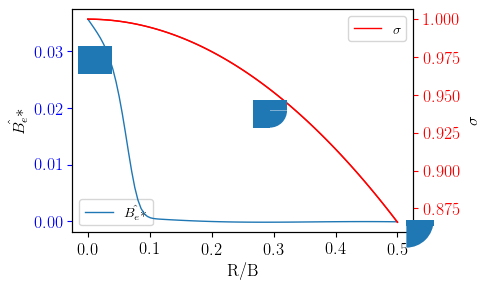

In [7]:
examples.eddy_sigma.show()

Ikeda made experiements on a number of two-dimensional cylinders with various sections <cite data-cite="7505983/4AFVVGNT"></cite>. Ikeda found that the eddy damping per unit length of these sections can be expressed as: <a id='eq_eddy_section'></a>

In [8]:
Equation(equations_ikeda_naked.eq_B_E0s, label='eq:eddy_section')

<src.notebook_to_latex.Equation object>

The total eddy damping can be obtained as an integral over the sections along the ship hull:

In [9]:
Equation(equations_ikeda_naked.eq_B_E0)

<src.notebook_to_latex.Equation object>

It can be seen from the section damping (eq. [here](#eq_eddy_section)) above that the eddy damping increases linearly with both roll amplitude and frequency, and that it will go to zero for small amplitudes and frequencies, which means that it is only included in the quadratic damping term ($B_2$). Ikeda expressed the $C_r$ coefficient to be entirely depending on the hull form.
Ikeda developed a regression formula for $C_r$ based on his experiments, which is used in the prediction method. The authors of this paper have tried to implement this method according to the description in the original paper <cite data-cite="7505983/4AFVVGNT"></cite> but have failed to reproduce the results from Ikeda's experiments exactly. Other resources such as <cite data-cite="7505983/FB64RGPF"></cite> and <cite data-cite="7505983/KAKIM2E2"></cite> have also been used without success.

Instead, a new regression for $C_r$ was made on the experimental results from <cite data-cite="7505983/4AFVVGNT"></cite>. The experimental results were collected by the authors using manual digitalization <cite data-cite="7505983/RXYIE6UW"></cite>.

In [10]:
examples.ikeda_section_table.show()

model,$\hat{\omega}$,$\phi_a$,$\hat{B_E}^*$,B_W+B_F,$L_{pp}$,$beam$,$T_s$,$\sigma$,$R_b$,$a_1$,$a_3$,$C_r$
A,0.7509999999999999,0.23,0.03753367571367666,0.0036357630291343353,0.8,0.28,0.11199999999999999,1.0,0.0,0.09572067327729883,-0.13851394050431068,6.791066236924095
A,0.507,0.24,0.028412505258521625,0.001390847207830892,0.8,0.28,0.11199999999999999,1.0,0.0,0.09572067327729883,-0.13851394050431068,7.297514558176523
B,0.7509999999999999,0.3,0.02070022681130489,0.003265431521957657,0.8,0.28,0.11199999999999999,0.997,0.01,0.09594956148239993,-0.13645394665840074,2.862276498613116
B,0.536,0.3,0.013327670129715686,0.0011106958095124797,0.8,0.28,0.11199999999999999,0.997,0.01,0.09594956148239993,-0.13645394665840074,2.5820572246775715
C,0.7509999999999999,0.27,0.006150584844546503,0.0021146614051981705,0.8,0.28,0.11199999999999999,0.995,0.02,0.09610173289389044,-0.13508440395498614,0.942686403519787
C,0.625,0.21,0.003986684713683185,0.0015000392814414284,0.8,0.28,0.11199999999999999,0.995,0.02,0.09610173289389044,-0.13508440395498614,0.9439893821974789
D,0.939,0.31,0.007465704560231518,0.0020385726488099023,0.8,0.28,0.11199999999999999,0.988,0.03,0.09663180060654622,-0.13031379454108408,0.7906835390460057
D,0.7509999999999999,0.31,0.006144708627086015,0.0015002944963602304,0.8,0.28,0.11199999999999999,0.988,0.03,0.09663180060654622,-0.13031379454108408,0.8136897536952459
G,0.8140000000000001,0.24,0.011504995055307304,0.08835564931140577,0.8,0.185,0.192,0.799,0.18239704162959489,-0.3470782119390985,-0.007600489480668136,0.08606062205238546
H,0.56,0.3,0.0006398363737784848,0.0014000371877776175,0.8,0.39799999999999996,0.193,0.893,0.19570204423684776,0.014252111702710376,-0.0688620354229256,0.0596772641355714


Where $OG/d=0$ for all sections. For the Series60 sections (G-K) the bilge radius $R_b$ was estimated using the following estimation, proposed by the authors:

In [11]:
Equation(equations_ikeda_naked.eq_R_b)

<src.notebook_to_latex.Equation object>

The nondimensional damping is expressed in <cite data-cite="7505983/4AFVVGNT"></cite> using an asterisk, or star symbol (*). The reason seems to be that Ikeda wanted to signal that
this damping only has the quadratic part of the damping. This stared
damping is defined as:

In [12]:
Equation(equations_ikeda_naked.eq_B_E_star_hat)

<src.notebook_to_latex.Equation object>

$\hat{B_E}^*$ and $(B_W+B_F)^*$ are the experimental values taken from <cite data-cite="7505983/4AFVVGNT"></cite>. Which add up to the total damping:

$\hat{B^*} = \hat{B^*_E} + (B_W+B_F)^*$

In [13]:
Equation(equations_ikeda_naked.eq_B_E_star_hat)

<src.notebook_to_latex.Equation object>

And the $C_r$ was calculated from the experiments as:

In [14]:
Equation(equations_ikeda_naked.eq_C_r_2)

<src.notebook_to_latex.Equation object>

Instead of trying to invent a complicated mathematical expression for the $C_r$ regression a simple decision tree model was instead fitted to the $C_r$ data from Ikeda's experiments. The fitted decision tree is illustrated in the figure below:

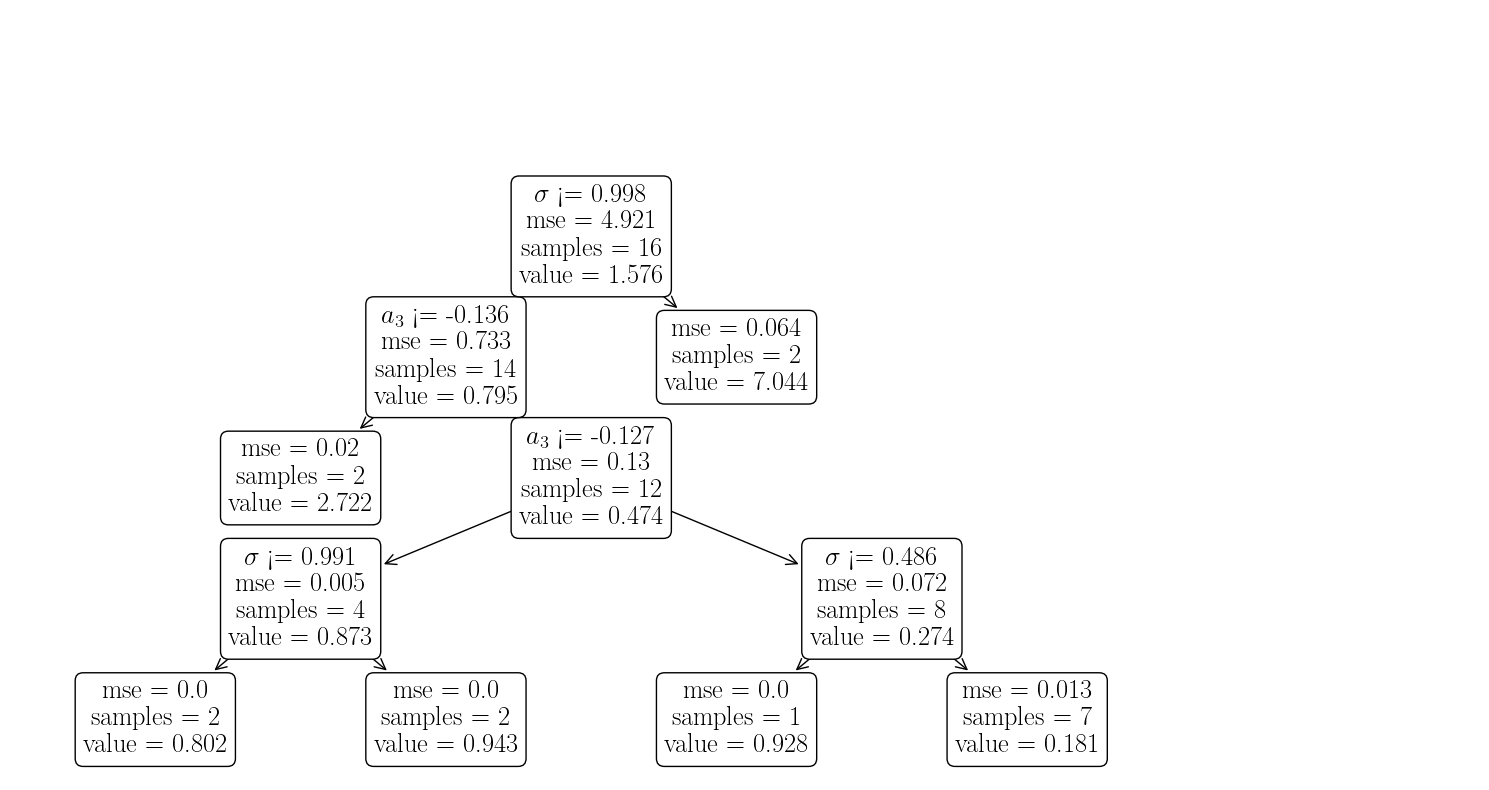

In [15]:
examples.decision_tree.show()

Even thoug this tree is very simple it has very good accuracy in reproducing the results from Ikedas experiments ($r^2=0.996)$.

## FNPF method
\label{fnpf-method}
Wave damping was obtained using PIT on roll decay simulation using the fully nonlinear potential flow method. This method is characterized by the application of the complete dynamic and kinematic free surface boundary conditions on the instantaneous free surface as well as the body-exact approach where the instantaneous wetted body surface is considered in the boundary value problem for the velocity potential, i.e. no linearizations are made to the governing equations of the potential flow problem.

The method used in this study employs a boundary element method (BEM) <cite data-cite="7505983/FD4N3DW2"></cite> to solve the boundary value problem for the velocity potential.

The free surface boundary conditions and the motions of the floating body introduce time dependency to the boundary value problem. The BEM is coupled with the mixed Eulerian-Lagrangian method (MEL) <cite data-cite="7505983/ZKB494GT"></cite> which is used for the evolution of free surface. A fourth-order Adams-Bashforth-Moulton time integral scheme is then used to evolve free surface and the rigid-body body motions in time.

The benefit with the FNPF method is the lack of linearizations to the free surface potential flow where all interactions between the undisturbed incident flow and surface piercing body is captured implicitly in the total velocity potential, including inviscid (wave) damping due to radiation and diffraction. The downside is the larger computational cost compared to many other potential flow based methods due to the fact that a boundary value problem for the velocity potential must be solved at least once every time step, depending on the specifics of the time integral scheme. However, FNPF methods are still typically less computationally demanding than for example URANS methods, making them attractive choices for seakeeping problems.

# Roll decay test

A common way to determine the roll damping of a ship is to
conduct a roll decay test. The initial heel angle during this test gives
the ship potential energy that subsequently is shifting to kinetic energy as the ship
starts to move during the inital phase of the roll decay test. The
energy is transfered between kinetic and potential energy during the
oscillations. The ship loses energy over time due to the damping wich
can be seen in this graph:

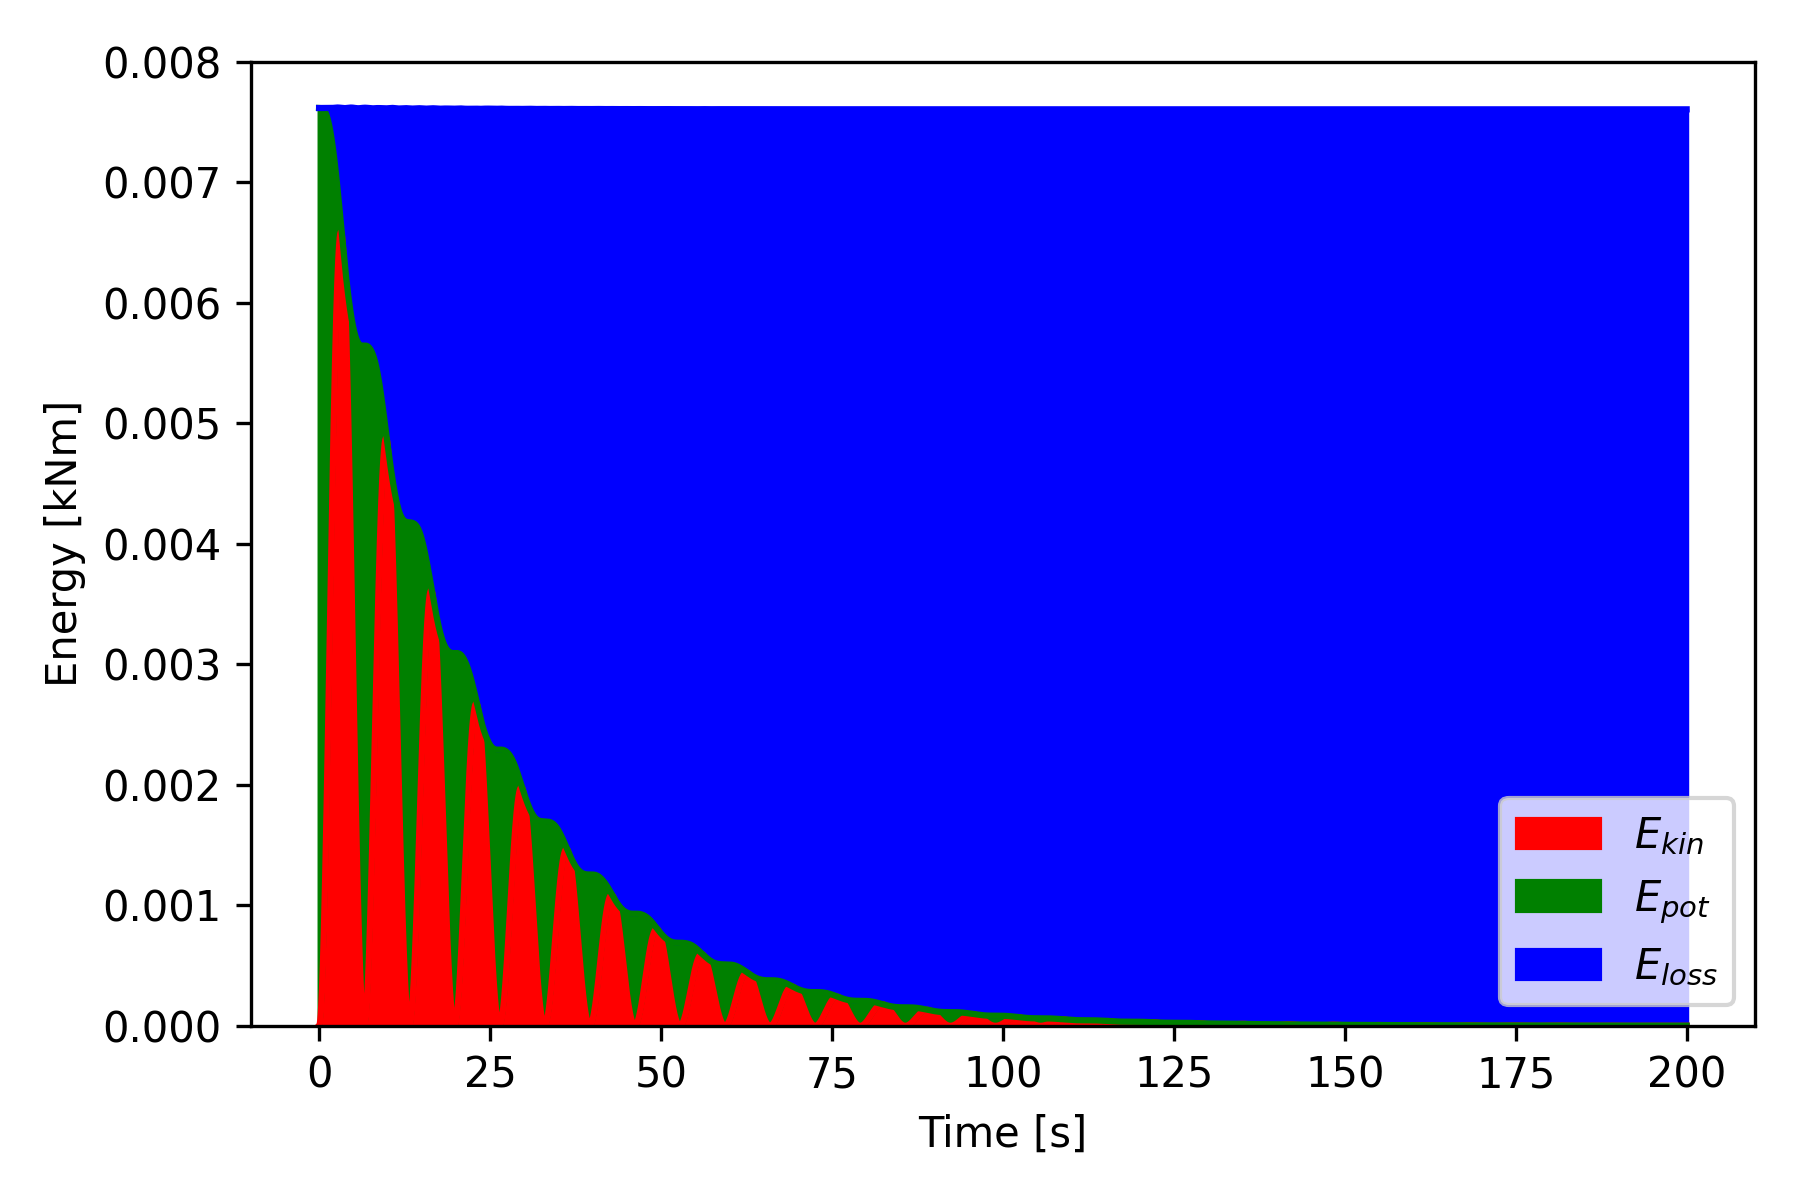

In [16]:
Image('../figures/energy_transfer.png')

Time traces of the roll motion from roll decay tests in model scale experiments as well as from FNPF simulations are used in this paper to determine the roll damping of KVLCC2. Two different techniques to identify the damping from these tests are used: the PIT method, described in the next section and the logartithmic decrement method as described in <cite data-cite="7505983/BYNJ8CFG"></cite>. [(and here)](02.1.appendix_extras.ipynb#se_time_and_frequency).

## PIT method

A parameters identification technique (PIT) similar to <cite data-cite="7505983/EXYJELCU"></cite> is used to obtain the damping coefficients from the roll decay model test as well as from the FNPF simulated roll decay tests. In this technique, parameters in a mathematical model are determined in order to get the best fit to a roll decay time signal. A derivation of a matematical model suitable for this study is described below together with a description of how the parameters: damping, stiffness and inertia coefficients are determined. The roll decay motion can be expressed in general form according to <cite data-cite="7505983/FB64RGPF"></cite>:

In [17]:
Equation(equations.roll_decay_equation_general_himeno)

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping and stiffness models:

In [18]:
Equation(equations.b44_cubic_equation)

<src.notebook_to_latex.Equation object>

In [19]:
Equation(equations.restoring_equation_cubic)

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [20]:
Equation(equations.roll_decay_equation_cubic, max_length=120)

<src.notebook_to_latex.Equation object>

This mathematical model can be reduced to a quadratic damping model when $B_3=0$ and a linear model when $B_2=B_3=0$. This equation does not have one unique solution however. If all parameters would be  multiplied by a factor $k$ these parameters would also yield as a solution to the equation. All parameters are therefore divided by the total added mass parameters $A_{44}$, replacing the parameters with new parameters such as:

In [21]:
Equation(equations.normalize_equations[symbols.B_1])

<src.notebook_to_latex.Equation object>

The equation is now rewritten with these new parameters which have unique solutions:

In [22]:
Equation(equations.roll_decay_equation_cubic_A, max_length=100)

<src.notebook_to_latex.Equation object>

The parameters of this equation can be identified using least square fit if the time signals $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are all known. This is the case for the results from the FNPF simulations but not from the model tests, where only the roll signal $\phi(t)$ is known. The other time derivatives can be estimated using numerical differentiation of a low-pass filtered roll signal or Kalman filtered roll signal. The filtering will however introduce some errors in itself. 
So instead of using this "Differentiation approach", it has been found that solving the differential equation numerically for guessed parameter values determined using optimization similarly to what was used by <cite data-cite="7505983/FJHQJJUH"></cite> and <cite data-cite="7505983/24TNAV5Z"></cite> gives the best parameter estimation. One problem with this "Integration approach" is that in order to converge, the optimization needs a resonable first guess of the parameters. The Differentiation approach has therefore been used as a pre-step to obtain a very good first guess of the parameters that can be passed on to the Integration approach. This has been used for both signals from FNPF and model tests where in the latter case numerical differentiation is used.

The differential equation is numerically solved as an intial value problem, where the initial states for $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are used to estimate the following states, by conducting very small time steps using the following expression for the acceleration: 

In [23]:
eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_cubic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

Equation(eq_phi1d, max_length=120)

<src.notebook_to_latex.Equation object>

This numerical solution can be compared with an analytical solution for a linear model [(See equations)](02.1.appendix_extras.ipynb#analytical). For this case the relation between $\zeta$ and $B_1$ can be expressed as: 

In [24]:
Equation(equations.B_1_zeta_eq)

<src.notebook_to_latex.Equation object>

and the natural frequency can be obtained from:

In [25]:
omega0_eq = equations.omega0_equation.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])
Equation(omega0_eq)

<src.notebook_to_latex.Equation object>

The analytical and numerical solutions are very similar according to the example: $A_{44} = 1.0$, $B_1 = 0.3$, $C_1 = 5.0$ shown in the figure below.

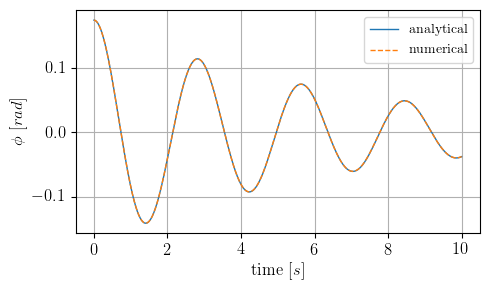

In [26]:
examples.analytical_numerical.show(omega0_lambda=omega0_lambda, 
                                   accelaration_lambda=accelaration_lambda);

# Validation study cases
\label{sec:validation}

The hybrid method in this paper is investigated using the well known KVLCC2 test case. This ship was selected partly because it is a well known test case and also because it does not have any bilge keels. Ikeda's method contain methods to predict damping from various components, where the bilge keels is one of them. Results from roll decay simulations made with the hybrid method will be compared to corresponding model test data from the SSPA Maritime Dynamics Laboratory. From these model tests, only the total damping can be observed. Reducing the number of components by having no bilge keels will therefore give more insight into the remaining components.

In [27]:
examples.KVLCC2.show()

title,LPP,B,ZCG,KXX,S,V,dens,ta,tf
KVLCC2,4.706,0.853,0.274,0.341,5.981,0.993,1000.0,0.3059,0.3059


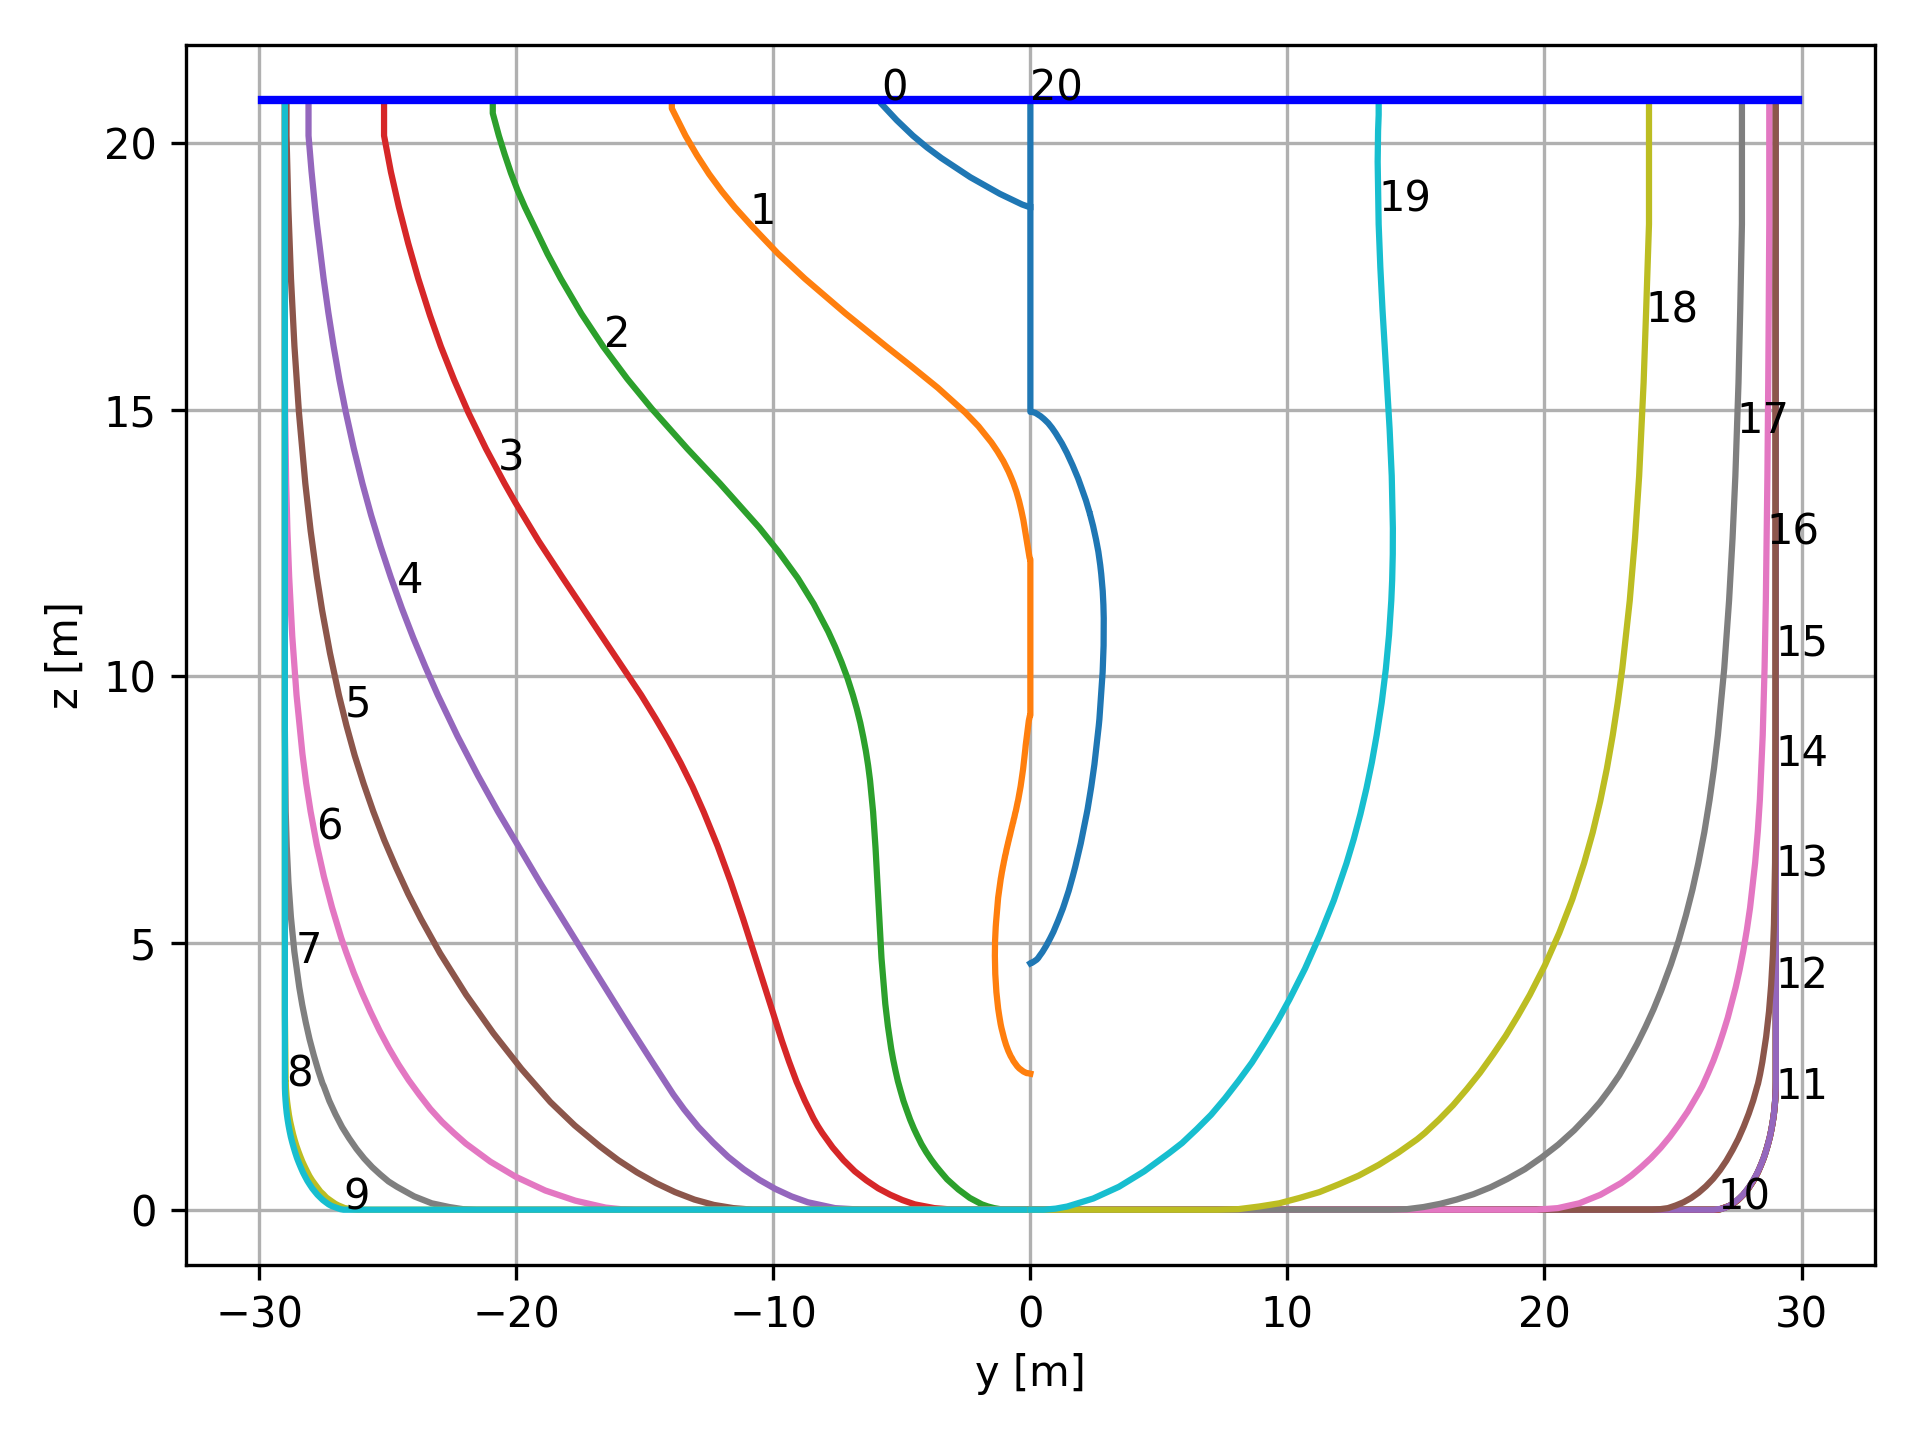

In [28]:
Image('../figures/KVLCC2_body_plan.png')

# Results

## Roll decay model tests
### 0 knots
Data from two roll decay model tests conducted at zero speed were available [(rolldecay)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#rolldecay). These tests where analyzed by fitting a cubic model [(cubic_model)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#cubic_model) to the model test data. The two models were very similar in terms of roll damping and stiffness (see fig.[here](#fig_mdl)), suggesting good repeatability in the model tests as well as in the parameter identification technique (PIT) used. The individual damping from each oscillation obtained with the logarithmic decrement method are very scattered, but this does not seem to influence the two models for the 0 speed case, which are very similiar.  

### 15.5 knots
Data from one roll decay model tests conducted at a ship speed corresponding to 15.5 knots full scale ship speed was also available (see fig.[here](#fig_mdl)). This model tests was analyzed in the same way as the other tests. It was found that the damping was higher at speed. The ship got a small yaw rate [(yaw rate)](../../notebooks/01.3_select_suitable_MDL_test_KLVCC2_speed.ipynb#yawrate) at the end of test, giving a small steady roll angle due to the centrifugal force. Since this effect is not included in the matematical model used, the steady roll angle was instead removed by removing the linear trend in the roll angle signal. 

In [29]:
models_mdl = examples.mdl.get_models()
df_results_mdl = examples.mdl.gather_results(models_mdl)

In [30]:
amplitudes = examples.mdl.analyze_amplitudes(models=models_mdl)

<a id='fig_mdl'></a>

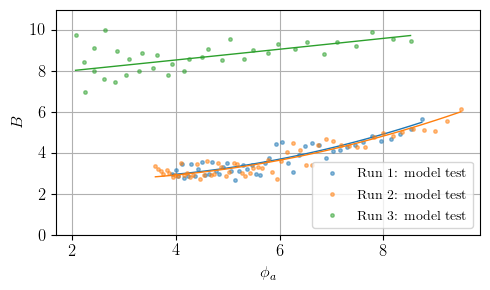

In [31]:
ylim=(0,11)
examples.mdl.show(amplitudes=amplitudes, df_results=df_results_mdl, ylim=ylim)

## Ikeda's method

The $C_r$ was predicted with Ikeda's method and the alternative decision tree model for the KVLCC2 with section data according to tab.[here](#tab_kvlcc2_section_table). A comparison is shown in the figure below, where it can be seen that the Ikeda implementation predicts much higher $C_r$ between station 8 and 14, where the bilge radius is also very small.

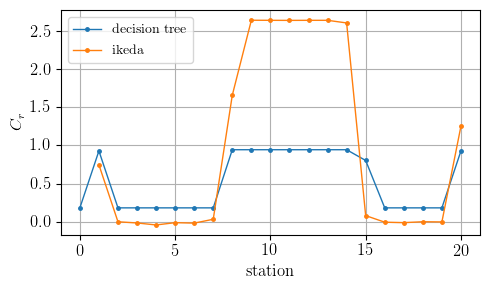

In [32]:
examples.decision_tree.show_KVLCC2_C_r_prediction()

When looking at predictions in fig.[(here)](#fig_ikeda) for KVLCC2 at 0 speed made with regular
Ikeda's method (left), it was found that the eddy damping $B_E$ was too high
compared to the model test results. Even though the rest of the components would also be
overpredicted, the $B_E$ would still be too large. The eddy damping calculated with $C_r$ predicted with the descision tree gave much better agreement.

In [33]:
models_motions, df_results_motions = reports.examples.FNPF.get_models_and_results()
amplitudes_motions = examples.FNPF.analyze_amplitudes(models=models_motions)

<a id='fig_ikeda'></a>

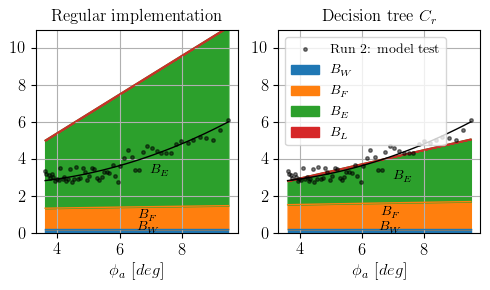

In [34]:
reports.examples.ikeda.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

## FNPF
Simulations of roll decay were conducted with FNPF for each model
test case. The results from these simulations can be seen in the figure
below.

In [35]:
df_results = df_results_mdl.append(df_results_motions)

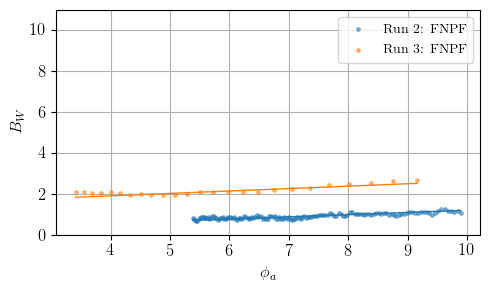

In [36]:
examples.FNPF.show(amplitudes=amplitudes_motions, df_results=df_results_motions, ylim=ylim)

The wave damping from FNFP seems to be reasonably linear at zero speed according the figure above, which is in line with Ikeda's assumption for the derivation of eddy damping <cite data-cite="7505983/4AFVVGNT"></cite>.

## Roll damping prediction with Hybrid method

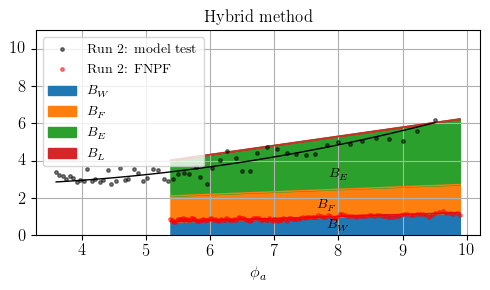

In [37]:
reports.examples.hybrid_0.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

The total damping from the hybrid method is similar to the model test results for the zero speed case. For the in speed case the agreement is however even better:

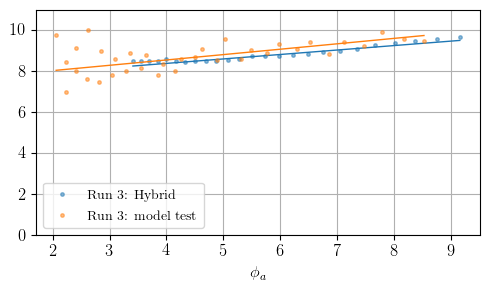

In [38]:
reports.examples.hybrid_speed.show_frequency(df_results=df_results, amplitudes=amplitudes, 
                                   amplitudes_motions=amplitudes_motions, 
                                   ylim=ylim)

Time series from: model test, FNPF invicid and hybrid method for Run 3 are shown in the figure below. The results from hybrid method and model test are very similar. It can be seen that the injection of semi empirical viscous damping in the hybrid method has given a significant improvement to the FNPF roll motion prediction.  

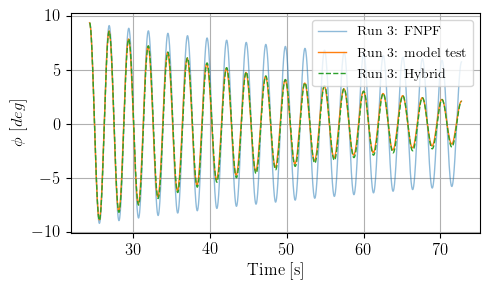

In [39]:
reports.examples.hybrid_speed.show_time(models_mdl=models_mdl, models_motions=models_motions)

The coefficients obtained from model tests, FNPF and Hybrid method are summarized in model scale units in the table below:

In [40]:
df_table = pd.merge(left=df_results, right=mdl_results.df_rolldecays, how='inner', 
         left_on='id', right_index=True, suffixes=('','_db'))

df_table['V'] = df_table['ship_speed']*1.852/3.6
df_table['fn'] = df_table['V']/np.sqrt(df_table['g']*df_table['lpp'])

interesting = ['paper_name','method','fn','omega0','B_1','B_2','B_3']

df_table_present = df_table[interesting].copy()
mask = df_table_present['method']!='FNPF'
df_table_present = df_table_present.loc[mask].copy()

renamers = {
    'paper_name' : 'run',
    'fn' : r'$F_n$',
    'omega0' : r'$\omega_0$',
    'B_1' : r'$B_1$',
    'B_2' : r'$B_2$',
    'B_3' : r'$B_3$',
}
df_table_present.rename(columns=renamers, inplace=True)
LateXTable(df_table_present.round(decimals=4), caption='Results', label='results')

run,method,$F_n$,$\omega_0$,$B_1$,$B_2$,$B_3$
1,model test,0.0,2.4614,2.9604,-6.5205,43.7754
2,model test,0.0,2.4611,2.8797,-5.8742,41.5037
3,model test,0.1423,2.4675,7.5233,7.0281,0.3898
3,Hybrid,0.1423,2.4418,7.5216,6.0148,0.0


# Conclusions
A hybrid method to predict ship roll motions has been proposed. The method combines an existing Fully Nonlinear Potential Flow Method (FNPF) with the viscous damping contributions from Ikeda's method. Simulations of roll decay test were in very good agreement with corresponding scale model tests. The method can be used to get more realistic roll motions in seakeeping simulations using potential flow calculations. This is important when roll motions is of primary interest, but can also influence other motions through coupling effects or the fact that the radiated waves from the roll motions are otherwise exaggerated. 

A potential error in Ikeda's method was found in the eddy damping prediction, which was revealed by comparison with Ikeda's original experiments. The implementation of the method did not reproduce the original results. Instead a new regression, using a decision tree model, was used to replace this part of the method. This reproduced the results from Ikeda's experiments and gave much better results with the hybrid method for KVLCC2 roll decay simulations in the present study.  


# References
<div class="cite2c-biblio"></div>

# Appendix

## Lewis sections

The Lewis section coefficients were calculated as:

In [41]:
Equation(equations_ikeda_naked.eq_D_1, max_length=300)

<src.notebook_to_latex.Equation object>

In [42]:
Equation(equations_ikeda_naked.eq_a_3)

<src.notebook_to_latex.Equation object>

In [43]:
Equation(equations_ikeda_naked.eq_a_1)

<src.notebook_to_latex.Equation object>

## KVLCC2
<a id='tab_kvlcc2_section_table'></a>

In [44]:
examples.KVLCC2_section_table.show()

$x$,$beam$,$T_s$,$\sigma$,$\frac{OG}{d}$,$R_b$,$a_1$,$a_3$
-0.0808,0.1712,0.0294,0.594,1.1,0.0976,0.5341,0.0935
0.1494,0.4102,0.2684,0.2433,0.1205,0.623,-0.1824,0.3651
0.4125,0.6151,0.3059,0.4922,0.1058,0.6672,0.0032,0.1916
0.6427,0.7394,0.3059,0.6537,0.1058,0.6041,0.1024,0.0836
0.9058,0.8259,0.3059,0.7858,0.1058,0.5021,0.1489,-0.0002
1.1361,0.851,0.3059,0.878,0.1058,0.3847,0.1542,-0.0576
1.3663,0.8529,0.3059,0.9445,0.1058,0.2596,0.1482,-0.0998
1.6294,0.8529,0.3059,0.9838,0.1058,0.1404,0.144,-0.1255
1.8596,0.8529,0.3059,0.9974,0.1058,0.0566,0.1425,-0.1345
2.1227,0.8529,0.3059,0.998,0.1058,0.0499,0.1424,-0.1349
